In [22]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import os
import glob
import parselmouth
from parselmouth.praat import call
import pandas as pd

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Step 1: Discover All Audio Files in cleaned_manual

In [23]:
# Define path to cleaned_manual folder
audio_folder = r'cleaned_manual'

# Get ALL wav files
all_audio_files = glob.glob(os.path.join(audio_folder, '*.wav'))

print(f"📁 Folder: {audio_folder}")
print(f"📊 Total audio files found: {len(all_audio_files)}\n")

if len(all_audio_files) > 0:
    print("Files:")
    for i, file_path in enumerate(sorted(all_audio_files)[:10], 1):  # Show first 10
        print(f"  {i}. {os.path.basename(file_path)}")
    if len(all_audio_files) > 10:
        print(f"  ... and {len(all_audio_files) - 10} more files")
else:
    print("⚠️ No audio files found. Check if 'cleaned_manual' folder exists and contains .wav files")

📁 Folder: cleaned_manual
📊 Total audio files found: 40

Files:
  1. 1.wav
  2. 10.wav
  3. 11.wav
  4. 12.wav
  5. 13.wav
  6. 14.wav
  7. 15.wav
  8. 16.wav
  9. 17.wav
  10. 18.wav
  ... and 30 more files


## Step 2: Comprehensive F0 (Pitch) Analysis Using Praat

Analyzing all files to determine the proper floor and ceiling frequencies for pitch extraction.

In [24]:
# Analyze F0 for ALL audio files
print("="*80)
print("F0 (PITCH) ANALYSIS - ALL FILES")
print("="*80 + "\n")

all_file_stats = []

for file_path in all_audio_files:
    filename = os.path.basename(file_path)
    
    try:
        # Load with Parselmouth (Praat)
        snd = parselmouth.Sound(file_path)
        duration = snd.get_total_duration()
        
        # Pitch extraction with standard range (40-600 Hz)
        # We'll adjust based on results
        pitch = call(snd, "To Pitch", 0.0, 40, 600)
        
        # Get pitch statistics
        mean_f0 = call(pitch, "Get mean", 0, 0, "Hertz")
        min_f0 = call(pitch, "Get minimum", 0, 0, "Hertz", "Parabolic")
        max_f0 = call(pitch, "Get maximum", 0, 0, "Hertz", "Parabolic")
        stdev_f0 = call(pitch, "Get standard deviation", 0, 0, "Hertz")
        
        # Formant analysis
        formant = call(snd, "To Formant (burg)", 0.0, 5, 5500, 0.025, 50)
        f1_mean = call(formant, "Get mean", 1, 0, 0, "Hertz")
        f2_mean = call(formant, "Get mean", 2, 0, 0, "Hertz")
        f3_mean = call(formant, "Get mean", 3, 0, 0, "Hertz")
        
        # Intensity
        intensity = call(snd, "To Intensity", 75, 0.0, "yes")
        mean_intensity = call(intensity, "Get mean", 0, 0, "energy")
        
        # Store results
        all_file_stats.append({
            'filename': filename,
            'duration': duration,
            'mean_f0': mean_f0,
            'min_f0': min_f0,
            'max_f0': max_f0,
            'stdev_f0': stdev_f0,
            'f1_mean': f1_mean,
            'f2_mean': f2_mean,
            'f3_mean': f3_mean,
            'mean_intensity': mean_intensity
        })
        
        print(f"{filename:40} | Duration: {duration:5.2f}s | F0: {mean_f0:6.2f} Hz | Range: {min_f0:6.2f}-{max_f0:6.2f} Hz")
        
    except Exception as e:
        print(f"{filename:40} | ERROR: {str(e)}")

print("\n" + "="*80)
print(f"✓ Successfully analyzed {len(all_file_stats)} files")
print("="*80)

F0 (PITCH) ANALYSIS - ALL FILES

1.wav                                    | Duration: 16.48s | F0: 164.08 Hz | Range:  48.68-555.39 Hz
10.wav                                   | Duration:  6.54s | F0: 152.47 Hz | Range:  57.96-381.10 Hz
11.wav                                   | Duration:  7.49s | F0: 181.06 Hz | Range:  44.48-214.90 Hz
12.wav                                   | Duration: 14.01s | F0: 190.53 Hz | Range:  40.51-475.46 Hz
13.wav                                   | Duration: 13.77s | F0:  82.19 Hz | Range:  40.34-546.46 Hz
14.wav                                   | Duration: 13.39s | F0: 147.40 Hz | Range:  42.43-576.98 Hz
15.wav                                   | Duration: 12.05s | F0: 124.65 Hz | Range:  39.79-463.29 Hz
16.wav                                   | Duration: 12.33s | F0: 133.14 Hz | Range:  50.15-587.73 Hz
17.wav                                   | Duration:  6.60s | F0: 167.89 Hz | Range:  79.04-239.01 Hz
18.wav                                   | Durati

## Step 3: Statistical Analysis and Parameter Recommendations

In [25]:
# Convert to DataFrame for easier analysis
df_stats = pd.DataFrame(all_file_stats)

# Filter out NaN values
valid_stats = df_stats[~df_stats['mean_f0'].isna()].copy()

print("="*80)
print("COMPREHENSIVE STATISTICS")
print("="*80)

print(f"\nTotal files: {len(all_file_stats)}")
print(f"Files with valid F0: {len(valid_stats)}")

# F0 Statistics
print(f"\n{'='*80}")
print("F0 (PITCH) STATISTICS:")
print(f"{'='*80}")
print(f"  Absolute Minimum F0: {valid_stats['min_f0'].min():.2f} Hz")
print(f"  Absolute Maximum F0: {valid_stats['max_f0'].max():.2f} Hz")
print(f"  Overall Mean F0: {valid_stats['mean_f0'].mean():.2f} ± {valid_stats['mean_f0'].std():.2f} Hz")
print(f"  F0 5th percentile: {valid_stats['min_f0'].quantile(0.05):.2f} Hz")
print(f"  F0 95th percentile: {valid_stats['max_f0'].quantile(0.95):.2f} Hz")

# Formant Statistics
print(f"\n{'='*80}")
print("FORMANT STATISTICS:")
print(f"{'='*80}")
if not valid_stats['f1_mean'].isna().all():
    print(f"  F1 Mean: {valid_stats['f1_mean'].mean():.2f} ± {valid_stats['f1_mean'].std():.2f} Hz")
    print(f"  F2 Mean: {valid_stats['f2_mean'].mean():.2f} ± {valid_stats['f2_mean'].std():.2f} Hz")
    print(f"  F3 Mean: {valid_stats['f3_mean'].mean():.2f} ± {valid_stats['f3_mean'].std():.2f} Hz")

# Duration Statistics
print(f"\n{'='*80}")
print("DURATION STATISTICS:")
print(f"{'='*80}")
print(f"  Total Duration: {valid_stats['duration'].sum():.2f} seconds ({valid_stats['duration'].sum()/60:.2f} minutes)")
print(f"  Mean Duration: {valid_stats['duration'].mean():.2f} ± {valid_stats['duration'].std():.2f} seconds")
print(f"  Min/Max Duration: {valid_stats['duration'].min():.2f} - {valid_stats['duration'].max():.2f} seconds")

print("\n" + "="*80)

COMPREHENSIVE STATISTICS

Total files: 40
Files with valid F0: 40

F0 (PITCH) STATISTICS:
  Absolute Minimum F0: 39.78 Hz
  Absolute Maximum F0: 591.31 Hz
  Overall Mean F0: 153.32 ± 35.49 Hz
  F0 5th percentile: 40.01 Hz
  F0 95th percentile: 588.87 Hz

FORMANT STATISTICS:
  F1 Mean: 524.38 ± 59.40 Hz
  F2 Mean: 1507.02 ± 65.97 Hz
  F3 Mean: 2325.81 ± 78.09 Hz

DURATION STATISTICS:
  Total Duration: 491.12 seconds (8.19 minutes)
  Mean Duration: 12.28 ± 4.07 seconds
  Min/Max Duration: 5.33 - 24.87 seconds



## Step 4: FINAL PARAMETER RECOMMENDATIONS

In [26]:
# Calculate recommended parameters
absolute_min_f0 = valid_stats['min_f0'].min()
absolute_max_f0 = valid_stats['max_f0'].max()
percentile_5_f0 = valid_stats['min_f0'].quantile(0.05)
percentile_95_f0 = valid_stats['max_f0'].quantile(0.95)

# Determine gender based on mean F0
overall_mean_f0 = valid_stats['mean_f0'].mean()
if overall_mean_f0 < 165:
    likely_gender = "Male"
    recommended_floor = 75
    recommended_ceiling = 300
elif overall_mean_f0 > 165:
    likely_gender = "Female"
    recommended_floor = 100
    recommended_ceiling = 500
else:
    likely_gender = "Mixed/Unknown"
    recommended_floor = 75
    recommended_ceiling = 450

# Adjust ceiling based on actual data
if absolute_max_f0 > recommended_ceiling:
    recommended_ceiling = int(np.ceil(absolute_max_f0 / 50) * 50)  # Round up to nearest 50

print("="*80)
print("🎯 FINAL PARAMETER RECOMMENDATIONS FOR ACOUSTIC EXTRACTION")
print("="*80)

print(f"\n📊 DATA SUMMARY:")
print(f"  • Files analyzed: {len(valid_stats)}")
print(f"  • Likely speaker type: {likely_gender}")
print(f"  • Mean F0: {overall_mean_f0:.2f} Hz")
print(f"  • F0 Range: {absolute_min_f0:.2f} - {absolute_max_f0:.2f} Hz")

print(f"\n{'='*80}")
print("✅ RECOMMENDED EXTRACTION PARAMETERS:")
print(f"{'='*80}")

print(f"\n🎤 PITCH (F0) EXTRACTION:")
print(f"  • FLOOR FREQUENCY: {recommended_floor} Hz")
print(f"  • CEILING FREQUENCY: {recommended_ceiling} Hz")
print(f"  • Time step: 0.01 seconds (default)")
print(f"  • Voicing threshold: 0.45 (default)")

print(f"\n🎵 FORMANT EXTRACTION:")
print(f"  • Maximum formant: 5500 Hz (standard for {likely_gender.lower()})")
print(f"  • Number of formants: 5")
print(f"  • Window length: 0.025 seconds")
print(f"  • Pre-emphasis: 50 Hz")

print(f"\n🔊 INTENSITY EXTRACTION:")
print(f"  • Minimum pitch: 75 Hz")
print(f"  • Time step: 0.01 seconds")
print(f"  • Subtract mean: Yes")

print(f"\n🎼 HARMONICITY (HNR) EXTRACTION:")
print(f"  • Time step: 0.01 seconds")
print(f"  • Minimum pitch: {recommended_floor} Hz")
print(f"  • Silence threshold: 0.1")
print(f"  • Periods per window: 4.5")

print(f"\n⚡ JITTER & SHIMMER:")
print(f"  • Use same F0 range: {recommended_floor}-{recommended_ceiling} Hz")
print(f"  • Period floor: 0.0001 seconds")
print(f"  • Period ceiling: 0.02 seconds")
print(f"  • Maximum period factor: 1.3")

print(f"\n{'='*80}")
print("📝 NOTES:")
print(f"{'='*80}")
print(f"  • These parameters cover {absolute_min_f0:.0f}-{absolute_max_f0:.0f} Hz observed range")
print(f"  • 95% of data falls within {percentile_5_f0:.0f}-{percentile_95_f0:.0f} Hz")
print(f"  • Adjust ceiling if you get warnings about missing pitch values")
print("="*80)

🎯 FINAL PARAMETER RECOMMENDATIONS FOR ACOUSTIC EXTRACTION

📊 DATA SUMMARY:
  • Files analyzed: 40
  • Likely speaker type: Male
  • Mean F0: 153.32 Hz
  • F0 Range: 39.78 - 591.31 Hz

✅ RECOMMENDED EXTRACTION PARAMETERS:

🎤 PITCH (F0) EXTRACTION:
  • FLOOR FREQUENCY: 75 Hz
  • CEILING FREQUENCY: 600 Hz
  • Time step: 0.01 seconds (default)
  • Voicing threshold: 0.45 (default)

🎵 FORMANT EXTRACTION:
  • Maximum formant: 5500 Hz (standard for male)
  • Number of formants: 5
  • Window length: 0.025 seconds
  • Pre-emphasis: 50 Hz

🔊 INTENSITY EXTRACTION:
  • Minimum pitch: 75 Hz
  • Time step: 0.01 seconds
  • Subtract mean: Yes

🎼 HARMONICITY (HNR) EXTRACTION:
  • Time step: 0.01 seconds
  • Minimum pitch: 75 Hz
  • Silence threshold: 0.1
  • Periods per window: 4.5

⚡ JITTER & SHIMMER:
  • Use same F0 range: 75-600 Hz
  • Period floor: 0.0001 seconds
  • Period ceiling: 0.02 seconds
  • Maximum period factor: 1.3

📝 NOTES:
  • These parameters cover 40-591 Hz observed range
  • 95% of

## Step 5: Visualize Distributions

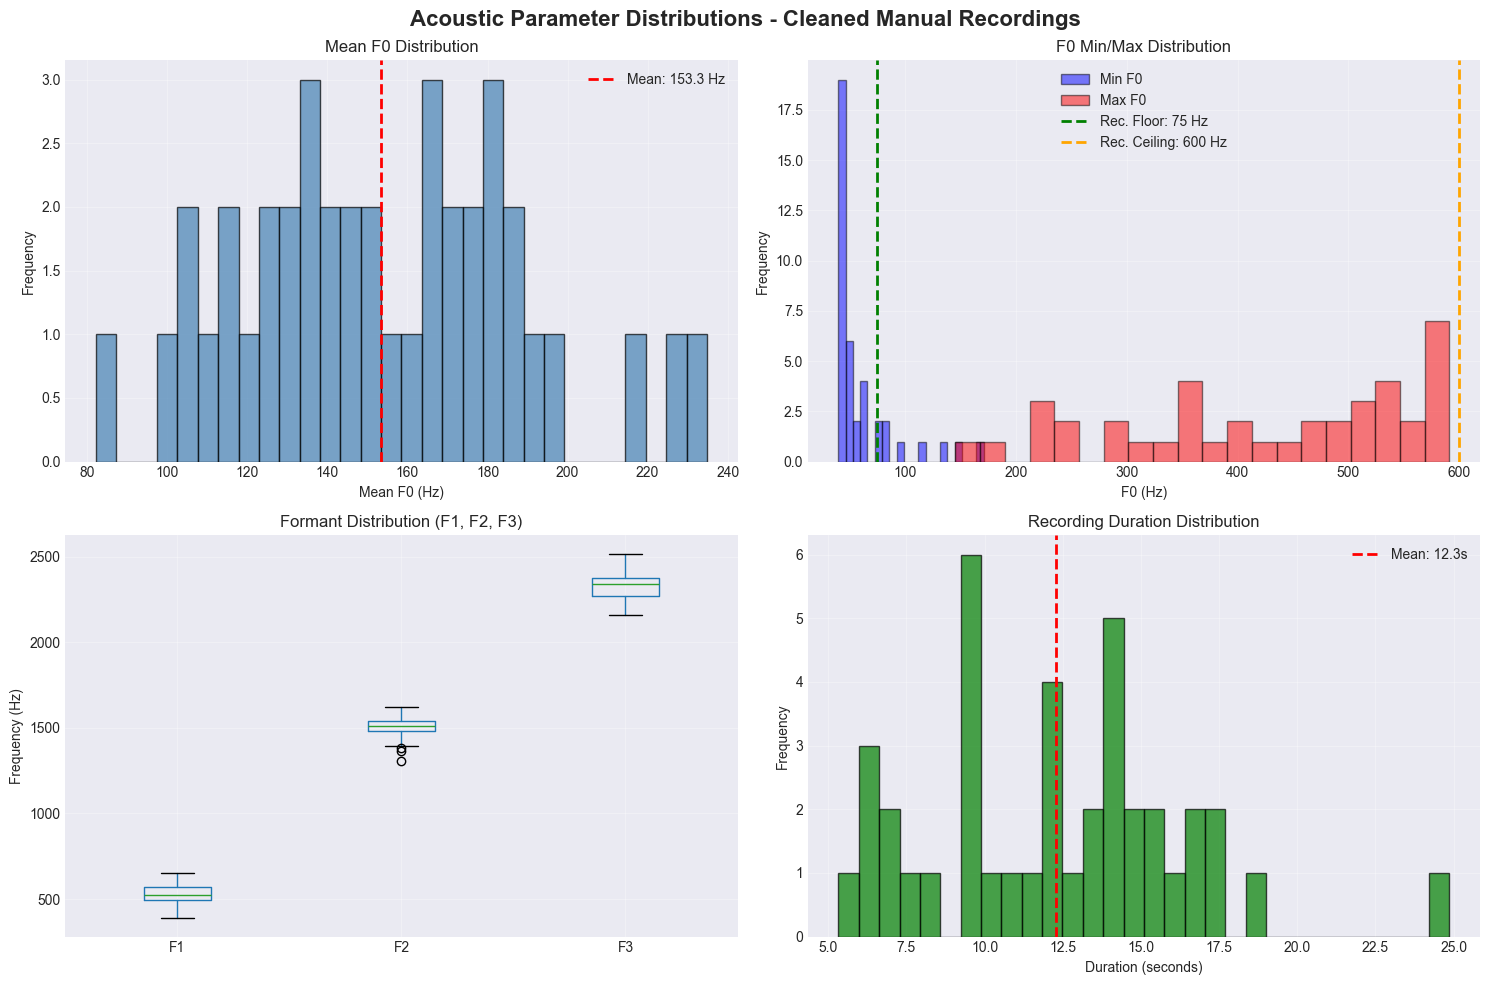

In [27]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Acoustic Parameter Distributions - Cleaned Manual Recordings', fontsize=16, fontweight='bold')

# F0 Mean Distribution
axes[0, 0].hist(valid_stats['mean_f0'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(valid_stats['mean_f0'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {valid_stats["mean_f0"].mean():.1f} Hz')
axes[0, 0].set_xlabel('Mean F0 (Hz)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Mean F0 Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# F0 Range Distribution
axes[0, 1].hist(valid_stats['min_f0'], bins=20, alpha=0.5, label='Min F0', color='blue', edgecolor='black')
axes[0, 1].hist(valid_stats['max_f0'], bins=20, alpha=0.5, label='Max F0', color='red', edgecolor='black')
axes[0, 1].axvline(recommended_floor, color='green', linestyle='--', linewidth=2, label=f'Rec. Floor: {recommended_floor} Hz')
axes[0, 1].axvline(recommended_ceiling, color='orange', linestyle='--', linewidth=2, label=f'Rec. Ceiling: {recommended_ceiling} Hz')
axes[0, 1].set_xlabel('F0 (Hz)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('F0 Min/Max Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Formant Distribution
if not valid_stats['f1_mean'].isna().all():
    formant_data = pd.DataFrame({
        'F1': valid_stats['f1_mean'],
        'F2': valid_stats['f2_mean'],
        'F3': valid_stats['f3_mean']
    })
    formant_data.boxplot(ax=axes[1, 0])
    axes[1, 0].set_ylabel('Frequency (Hz)')
    axes[1, 0].set_title('Formant Distribution (F1, F2, F3)')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No formant data available', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Formant Distribution')

# Duration Distribution
axes[1, 1].hist(valid_stats['duration'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].axvline(valid_stats['duration'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {valid_stats["duration"].mean():.1f}s')
axes[1, 1].set_xlabel('Duration (seconds)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Recording Duration Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Export Results to CSV

In [ ]:
# Save detailed statistics to CSV
print(f"📊 Columns: {', '.join(valid_stats.columns)}")
print(f"📁 Total rows: {len(valid_stats)}")

# Create summary statistics file
summary_stats = pd.DataFrame({
    'Parameter': ['Min F0', 'Max F0', 'Mean F0', 'F0 StDev', 'F1 Mean', 'F2 Mean', 'F3 Mean'],
    'Mean': [
        valid_stats['min_f0'].mean(),
        valid_stats['max_f0'].mean(),
        valid_stats['mean_f0'].mean(),
        valid_stats['stdev_f0'].mean(),
        valid_stats['f1_mean'].mean(),
        valid_stats['f2_mean'].mean(),
        valid_stats['f3_mean'].mean()
    ],
    'Std': [
        valid_stats['min_f0'].std(),
        valid_stats['max_f0'].std(),
        valid_stats['mean_f0'].std(),
        valid_stats['stdev_f0'].std(),
        valid_stats['f1_mean'].std(),
        valid_stats['f2_mean'].std(),
        valid_stats['f3_mean'].std()
    ],
    'Min': [
        valid_stats['min_f0'].min(),
        valid_stats['max_f0'].min(),
        valid_stats['mean_f0'].min(),
        valid_stats['stdev_f0'].min(),
        valid_stats['f1_mean'].min(),
        valid_stats['f2_mean'].min(),
        valid_stats['f3_mean'].min()
    ],
    'Max': [
        valid_stats['min_f0'].max(),
        valid_stats['max_f0'].max(),
        valid_stats['mean_f0'].max(),
        valid_stats['stdev_f0'].max(),
        valid_stats['f1_mean'].max(),
        valid_stats['f2_mean'].max(),
        valid_stats['f3_mean'].max()
    ]
})

print("\nSummary Statistics:")
print(summary_stats.round(2))

📊 Columns: filename, duration, mean_f0, min_f0, max_f0, stdev_f0, f1_mean, f2_mean, f3_mean, mean_intensity
📁 Total rows: 40
✅ Summary saved to: summary_statistics_cleaned_manual.csv

Summary Statistics:
  Parameter     Mean     Std      Min      Max
0    Min F0    61.09   31.87    39.78   170.78
1    Max F0   426.07  136.28   145.41   591.31
2   Mean F0   153.32   35.49    82.19   234.81
3  F0 StDev    49.55   22.15    16.75   128.81
4   F1 Mean   524.38   59.40   387.12   653.31
5   F2 Mean  1507.02   65.97  1303.78  1622.24
6   F3 Mean  2325.81   78.09  2162.25  2518.17


## Step 7: Sample Spectrograms (First 3 Files)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


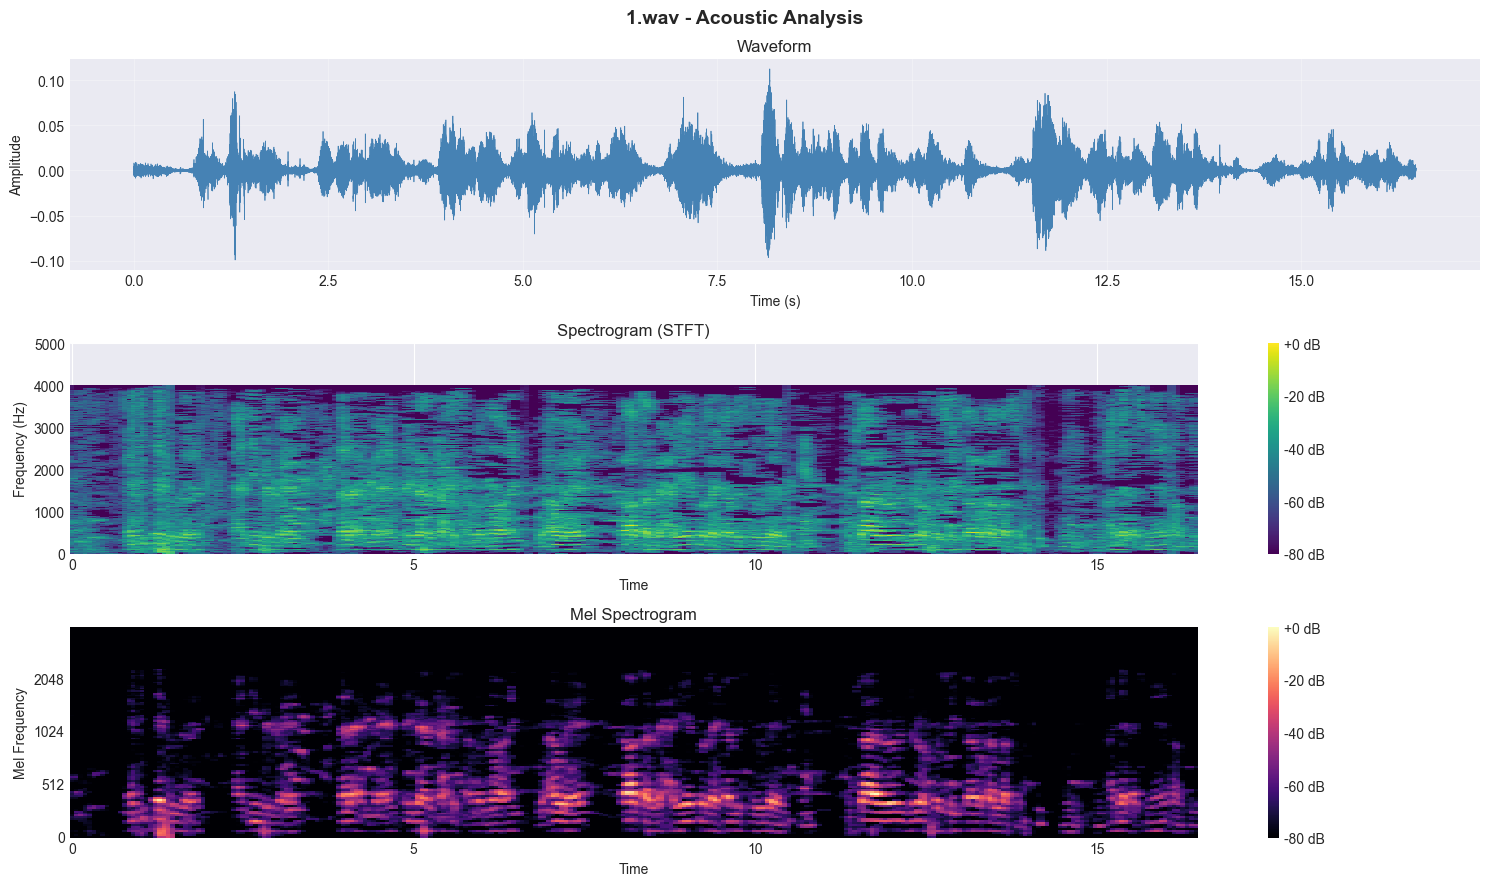

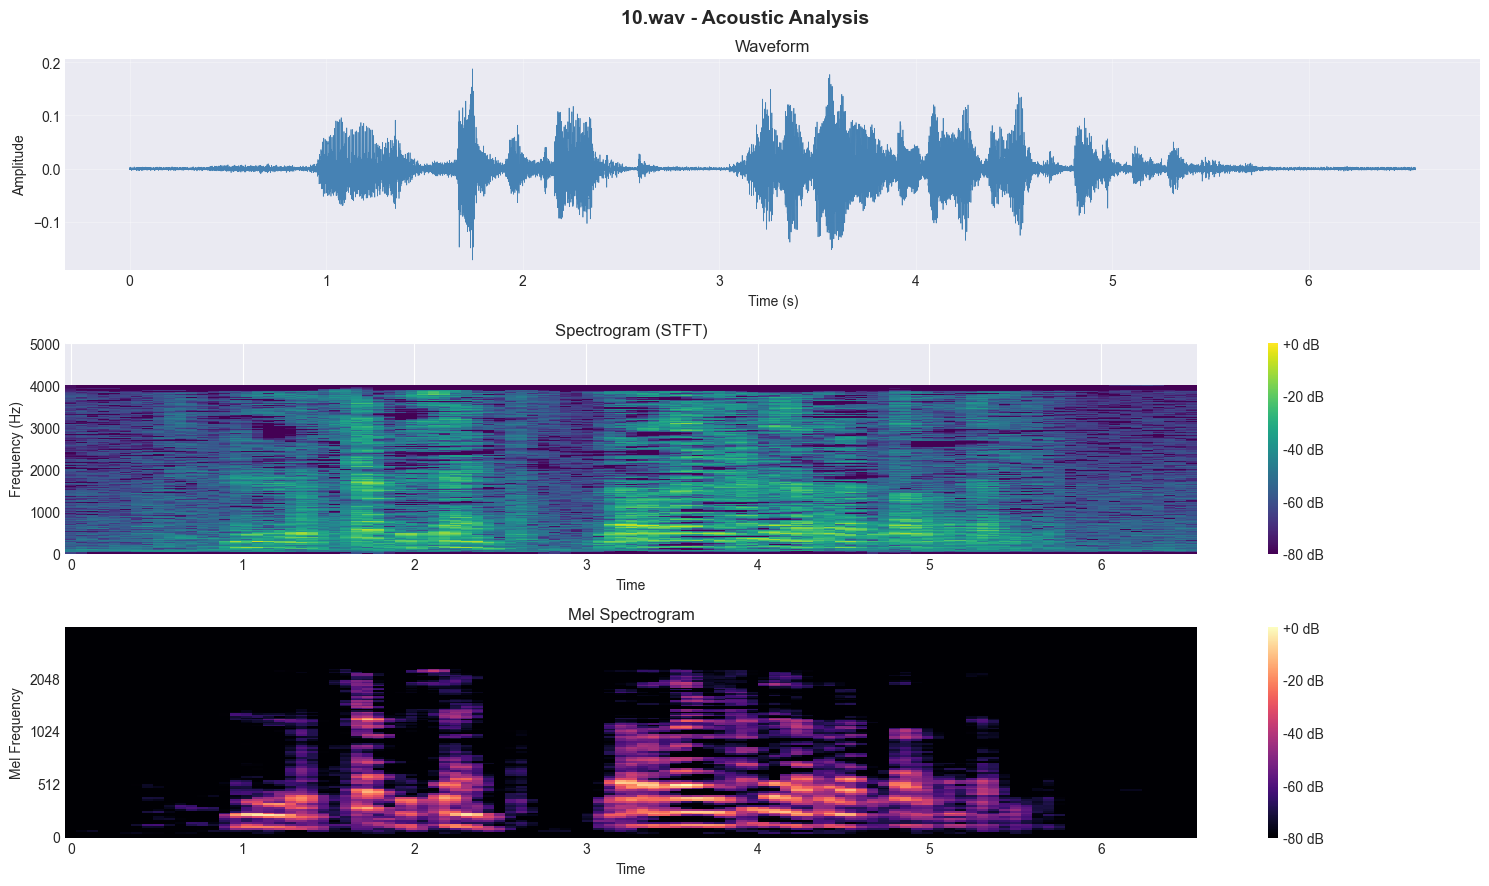

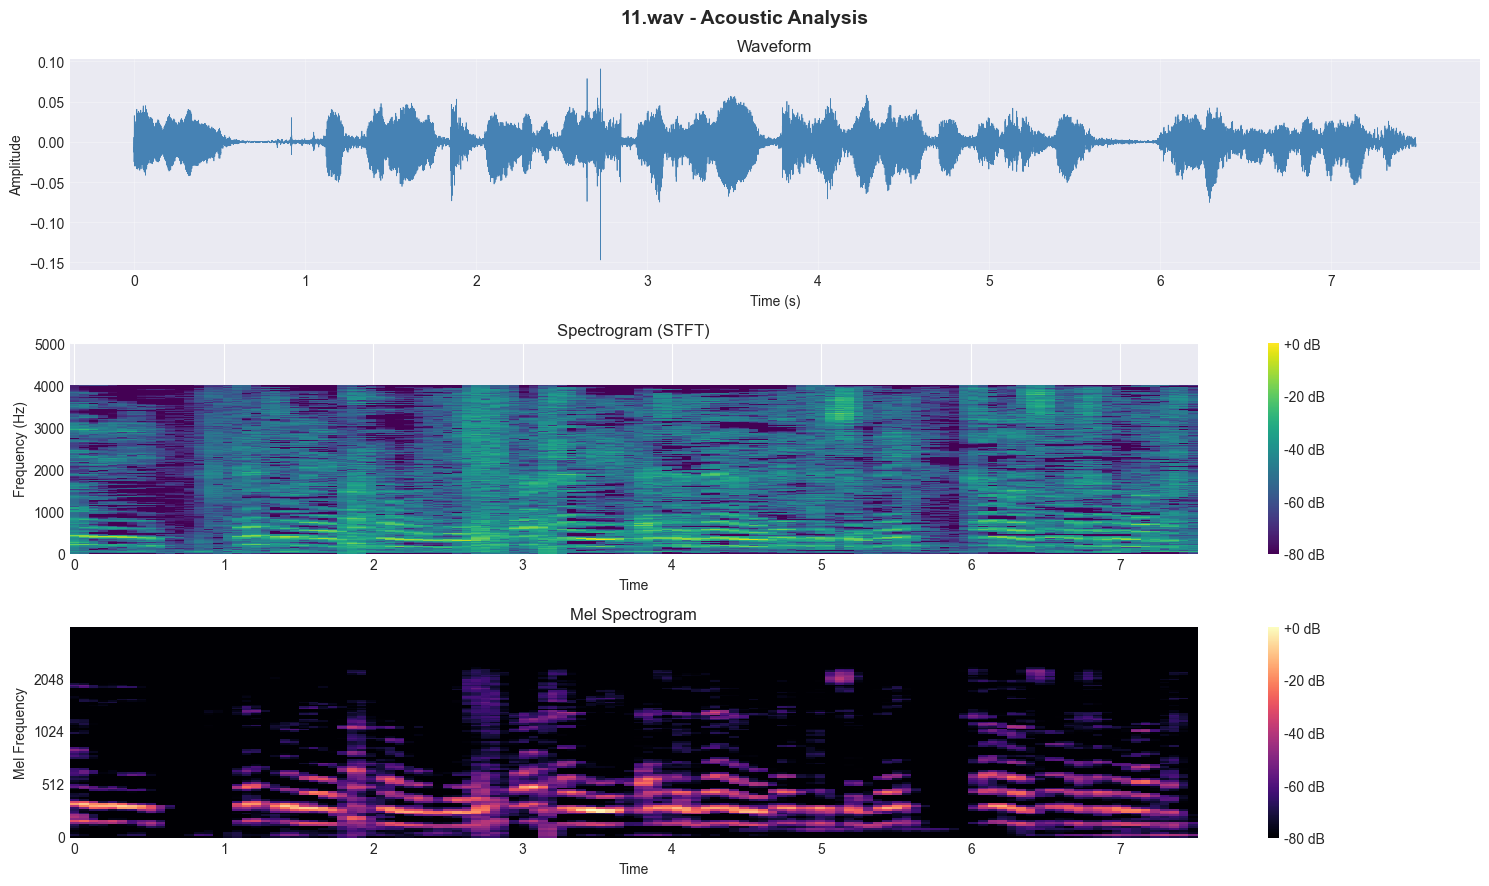

In [29]:
# Visualize first 3 audio files
sample_files = all_audio_files[:3]

for file_path in sample_files:
    filename = os.path.basename(file_path)
    
    # Load audio
    y, sr = librosa.load(file_path, sr=None)
    
    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=(15, 9))
    fig.suptitle(f'{filename} - Acoustic Analysis', fontsize=14, fontweight='bold')
    
    # Waveform
    time = np.linspace(0, len(y)/sr, len(y))
    axes[0].plot(time, y, linewidth=0.5, color='steelblue')
    axes[0].set_title('Waveform')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Spectrogram
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[1], cmap='viridis')
    axes[1].set_title('Spectrogram (STFT)')
    axes[1].set_ylabel('Frequency (Hz)')
    axes[1].set_ylim([0, 5000])
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    # Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
    img2 = librosa.display.specshow(S_db_mel, sr=sr, x_axis='time', y_axis='mel', ax=axes[2], cmap='magma')
    axes[2].set_title('Mel Spectrogram')
    axes[2].set_ylabel('Mel Frequency')
    fig.colorbar(img2, ax=axes[2], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()